# WQ_ML_GROUP_3 - G

## Submission 1: Data Preparation

Group Member:

1. Ugochukwu Nnalue
2. Aliaksandr Panko
3. Ntui Gideon Ateke
4. Oliseamaka Olise
5. Olawale Dosunmu


# Data Analysis

The following data analysis is performed on a series of E-mini S&P 500 futures tick data:

1. Form tick, volume, and dollar bars
2. Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot a time seiries of that bar count. What bar type produces the most stable weekly count? Why?
3. Compute serieal correlation of returns for the three bar types. What bar method has the lowest serial correlation?
4. Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?
5. Standardize & Plot the Distributions

# Task 1. Bars raw data generation

To generate the data we installed a virtual machine with Ubuntu. Secondly, we downloaded the files the GitHub [repository](https://github.com/Jackal08/financial-data-structures) (link was provided in a task description). From the repo we used next files:
1. ES_Trades.csv - a file with raw data
2. main.py  - python code
3. ReadMe.md
4. requirements_pip.txt
5. setup.py
6. cython_loops.pyx

In Ubuntu Terminal we executed next steps: 

1. Go to the directory where you have saved the file, example: cd Desktop/bars/awesome/
2. pip install -r pip_requirements.txt
3. python setup.py  build_ext --inplace 
4. python main.py

This sequence of steps runs the main.py file, which contains next functions:
1. pre_process(data) - Creates an date time objects
2. extract_data(data)  
3. time_bars(data, units) 
4. dollar_bars(data, units)
5. volume_bars(data, units)
6. tick_bars(data, units)
7. create_bars(data, units=1000, type='tick') - Creates the desired bars based on previous functions of data preprocessing
8. The body: reads raw tick data => creates bars => writes bars data to .csv files

In [ ]:
import cython_loops
%matplotlib inline

In [ ]:
# main.py  - should be run from ubuntu terminal after running a setup file

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
import cython_loops

# Functions
def __pre_process(data):
    # Create an date time
    data['Date_Time'] = data['Date'] + ' ' + data['Time']
    data = data.drop(['Date', 'Time'], axis=1)

    # Calculate the transaction value
    data['Transaction'] = data['Price'] * data['Volume']

    return data


def __extract_data(data):
    # Extract data
    date_time = data[['Date_Time', 'Group']].groupby('Group')['Date_Time'].last()
    ohlc = data[['Price', 'Group']].astype(float).groupby('Group')['Price'].ohlc()
    volume = data[['Volume', 'Group']].astype(float).groupby('Group').sum()
    vwap = pd.DataFrame(data[['Transaction', 'Group']].astype(float).groupby('Group').sum().values / volume.values)

    # Create DataFrame
    bars = pd.concat([date_time, ohlc, volume, vwap], axis=1)
    bars.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'vwap']

    return bars


def __time_bars(data, units):
    # Set the time frame
    duration = str(units) + 'T'

    # Extract data
    data.index = pd.to_datetime(data['Date_Time'])
    ohlc = data.resample(duration, label='right')['Price'].ohlc()
    date_time = pd.DataFrame(ohlc.index, index=ohlc.index)
    volume = data.resample(duration, label='right')['Volume'].sum()
    vwap = data.resample(duration, label='right')['Transaction'].sum().values / volume

    # Create DataFrame
    data = pd.concat([date_time, ohlc, volume, vwap], axis=1)
    data.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'vwap']

    return data


def __dollar_bars(data, units):
    # Dollar metric
    data['CumDollars'] = data['Transaction'].cumsum()
    col_names = data.columns

    # Set the relevant group for each row
    data = cython_loops.set_row_groups(units, np.array(data))
    data = pd.DataFrame(data, columns=col_names)
    data = __extract_data(data)

    return data


def __volume_bars(data, units):
    # Volume metric
    data['CumVol'] = data['Volume'].cumsum()
    col_names = data.columns

    # Set the relevant group for each row
    data = cython_loops.set_row_groups(units, np.array(data))
    data = pd.DataFrame(data, columns=col_names)
    data = __extract_data(data)

    # Todo: Add 1/50 of the daily traded volume
    return data


def __tick_bars(data, units):
    # Create groups based on number of tick bars
    group_index = data.index % units == 0
    group_size = ceil(data.shape[0] / float(units))
    groups = np.array(range(0, int(group_size)))

    # Fill in group values
    data.loc[group_index, 'Group'] = groups
    data['Group'] = data['Group'].ffill()
    data = __extract_data(data)

    return data


def create_bars(data, units=1000, type='tick'):
    """
    Creates the desired bars. 4 different types:
    1. Time Bars
    2. Tick Bars
    3. Volume Bars
    4. Dollar Bars

    See book for more info:
    Marcos Prado (2018), Advances in Financial Machine Learning, pg 25

    :param data: Pandas DataFrame of Tick Data from TickData.com
    :param units: Number of units in a bar.
                  Time Bars: Number of minutes per bar
                  Tick Bars: Number of ticks per bar
                  Volume Bars: Number of shares traded per bar
                  Dollar Bars: Transaction size traded per bar

    :param type: String of the bar type, ('tick', 'volume', 'dollar', 'time')
    :return: Pandas DataFrame of relevant bar data
    """
    data = __pre_process(data)

    # Create an empty column
    data['Group'] = np.nan

    print('Creating {type} bars'.format(type=type))
    if type == 'tick':
        bars = __tick_bars(data, units)
    elif type == 'volume':
        bars = __volume_bars(data, units)
    elif type == 'dollar':
        bars = __dollar_bars(data, units)
    elif type == 'time':
        bars = __time_bars(data, units)
    else:
        raise ValueError('Type must be: tick, volume, dollar, or time')

    return bars


# ------------------------
# Body
if __name__ == '__main__':
    # Read in tick data:
    # https://s3-us-west-2.amazonaws.com/tick-data-s3/downloads/ES_Sample.zip
    data = pd.read_csv('raw_tick_data/ES_Trades.csv')

    # Create bars
    #time_bars = create_bars(data, units=600, type='time')  
    tick_bars = create_bars(data, units=5000, type='tick')
    volume_bars = create_bars(data, units=21731, type='volume')
    dollar_bars = create_bars(data, units=35638840, type='dollar')

    # Write to csv
    #time_bars.to_csv('saved_data/time_bars.csv', index=False)
    tick_bars.to_csv('saved_data/tick_bars.csv', index=False)
    volume_bars.to_csv('saved_data/volume_bars.csv', index=False)
    dollar_bars.to_csv('saved_data/dollar_bars.csv', index=False)

# Step 2: Count the number of bars during  a week
After the first step we have data for 3 bars:
1. TimeStamp of a bar creation
2. Open price
3. High price
4. Low price
5. Close price
6. Volume 

Using this data we can count how many bars are created during a week.

In [11]:
# import Data & Convert Index to DateTime

# here you need to use a path to the folder with 4 .csv files with bars data, generated in main.py
path = 'D:/'  

#time_bars = pd.read_csv(path + 'time_bars.csv', index_col='date')
tick_bars = pd.read_csv(path + 'tick_bars.csv', index_col='date')
volume_bars = pd.read_csv(path + 'volume_bars.csv', index_col='date')
dollar_bars = pd.read_csv(path + 'dollar_bars.csv', index_col='date')

#time_bars.index = pd.to_datetime(time_bars.index)
tick_bars.index = pd.to_datetime(tick_bars.index)
volume_bars.index = pd.to_datetime(volume_bars.index)
dollar_bars.index = pd.to_datetime(dollar_bars.index)

# Let's have a look at dollar bars data frame:
dollar_bars.head()

,open,high,low,close,volume,vwap
date,,,,,,
2013-09-01 18:18:58.662,1640.25,1642.00,1639.00,1641.25,21722.0,1640.667273
2013-09-01 21:42:07.388,1641.25,1643.50,1639.75,1640.75,21706.0,1641.830116
2013-09-02 02:05:25.233,1640.75,1644.50,1640.50,1644.50,21652.0,1643.149905
2013-09-02 03:01:56.174,1644.50,1646.00,1642.75,1645.00,21709.0,1644.556854
2013-09-02 04:32:44.340,1645.00,1647.25,1644.25,1645.50,21646.0,1646.012254


# Step 3 Plot the time series of the bar count 

In [16]:
#time_count = time_bars['close'].resample('W', label='right').count()
tick_count = tick_bars['close'].resample('W', label='right').count()
volume_count = volume_bars['close'].resample('W', label='right').count()
dollar_count = dollar_bars['close'].resample('W', label='right').count()

count_df = pd.concat([ tick_count, volume_count, dollar_count], axis=1) # time_count is not used in our pro
count_df.columns = ['tick', 'volume', 'dollar'] #'time', 

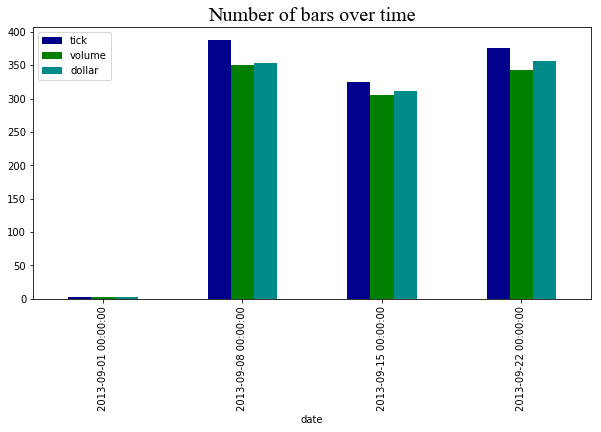

In [17]:
# Plot
count_df.plot(kind='bar', figsize=[10, 5], color=('darkblue', 'green', 'darkcyan')) # 'darkred' - for time
plt.title('Number of bars over time', loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.show()

## Review
Since we analize the data in weekly basis, having only 20 days, it is obvious that only 4 observations (basicaly 3, the first one is clearly not valid) it is not enough to make any reasonable conclution.

However we came up with a good suggestion that volume bars should be more stable than dollars one. This can be explained from the assumption that stock prices normaly rise (considering long run). Since, by construction, the dollar threshold is constant, there must be a tendency for dollar bars frequency gets higher with time. Volume in our opinion should be more stable. 

For tick and volume it's difficult to say, which one is more stable (should be both more or less ok, but we need more data to prove or disprove it)

# Step 4 Serieal correlation

In [18]:
# time_returns = np.log(time_bars['close']).diff().dropna()
tick_returns = np.log(tick_bars['close']).diff().dropna()
volume_returns = np.log(volume_bars['close']).diff().dropna()
dollar_returns = np.log(dollar_bars['close']).diff().dropna()

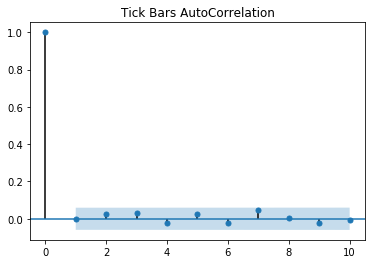

In [20]:
plot_acf(tick_returns, lags=10)
plt.title('Tick Bars AutoCorrelation')
plt.show()

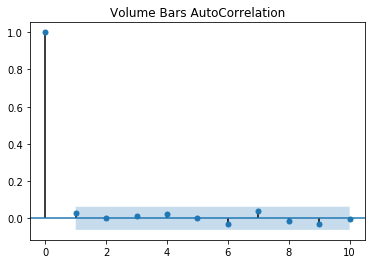

In [21]:
plot_acf(volume_returns, lags=10)
plt.title('Volume Bars AutoCorrelation')
plt.show()

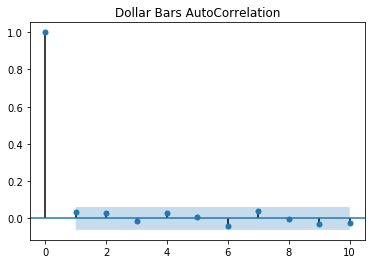

In [22]:
plot_acf(dollar_returns, lags=10)
plt.title('Dollar Bars AutoCorrelation')
plt.show()

In [26]:
import statsmodels
print("Ticks:", statsmodels.tsa.stattools.acf(tick_returns, unbiased=False, nlags=10))
print("Volumes:", statsmodels.tsa.stattools.acf(volume_returns, unbiased=False, nlags=10))
print("Dollars:", statsmodels.tsa.stattools.acf(dollar_returns, unbiased=False, nlags=10))


Ticks: [ 1.         -0.00276167  0.02630948  0.03284656 -0.02103088  0.02576505
 -0.02387176  0.04601623  0.00682906 -0.02289795 -0.00601301]
Volumes: [ 1.00000000e+00  3.08209007e-02 -6.88619245e-04  9.98670611e-03
  2.13429711e-02  6.31033914e-04 -2.90009918e-02  4.02920865e-02
 -1.32732521e-02 -3.19375535e-02 -5.37230457e-03]
Dollars: [ 1.          0.03317971  0.02975551 -0.0138003   0.02689441  0.00732739
 -0.04240176  0.0386564  -0.00574672 -0.02969557 -0.02573944]


## Review

Based on acf() output we can conclude that all 3 series don't have autocorrelation. From the result above we conclude that the bars have more or less the same serial correlation.

# Step 5 Jarque-Bera normality test.

In [33]:
from scipy import stats

In [42]:
print ('Test Statistics:')
#print 'Time:', '\t', int(stats.jarque_bera(time_returns)[0])
print ('Tick:',stats.jarque_bera(tick_returns))
print ('Volume:',stats.jarque_bera(volume_returns))
print ('Dollar:',stats.jarque_bera(dollar_returns))


Test Statistics:
Tick: (4521.614456877212, 0.0)
Volume: (4911.461089251519, 0.0)
Dollar: (11916.740046491339, 0.0)


## Review
Jarque-Bera normality test has H0 that the series is normaly distributed. The first value in output is test statistics, the second is p-value. 

We can conlude that the lowest test statistics has Tick time series, but what even more importent that we reject the H0 of normality for all the series.